In [1]:
import os, sys
import numpy as np
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
from sklearn.metrics import accuracy_score
import tensorflow as tf
from model_profiler import model_profiler
import keras.backend as K
tf.__version__

'2.6.2'

In [2]:
# check GPU
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
# choose GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
tf.config.experimental.set_memory_growth(gpus[1], True)

In [4]:
RANDOM_STATE = 111
BATCH_SIZE = 256
EPOCHS = 30
LR = 1e-4

In [5]:
dir_path = '../data/'

train, train_labels = [], []
with open(dir_path + 'train.txt', 'r') as f:
  for line in f:
    data = line.split(" ")
    train.append(dir_path + data[0])
    train_labels.append(data[1].replace('\n', ''))


val, val_labels = [], []
with open(dir_path + 'val.txt', 'r') as f:
  for line in f:
    data = line.split(" ")
    val.append(dir_path + data[0])
    val_labels.append(data[1].replace('\n', ''))


test, test_labels = [], []
with open(dir_path + 'test.txt', 'r') as f:
  for line in f:
    data = line.split(" ")
    test.append(dir_path + data[0])
    test_labels.append(data[1].replace('\n', ''))

print(f'訓練資料共{len(train)}筆')
print(f'驗證資料共{len(val)}筆')
print(f'測試資料共{len(test)}筆')

訓練資料共63325筆
驗證資料共450筆
測試資料共450筆


### 資料前處理

In [6]:
def data_preprocess(paths):
    features = []
    for path in tqdm(paths):
        # 讀取image，並轉為灰階影像
        img = cv2.imread(path, 0)
        img = cv2.resize(img, (32, 32))
        img = img.reshape(32, 32, 1).astype('float32')
        # 標準化(MaxAbs)，灰階影像最大為255
        img = img / 255
        features.append(img)
        
    return features

In [7]:
%%time
train_features = data_preprocess(train)
val_features = data_preprocess(val)
test_features = data_preprocess(test)

  0%|          | 0/63325 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

CPU times: user 33.1 s, sys: 1.43 s, total: 34.6 s
Wall time: 34.4 s


### OneHotEncoding

In [8]:
# 轉成np.array再轉成oneHotEncoding
def OneHotEncoding(labels):
    y = np.eye(50)[np.array(list(map(int, labels)))]
    # y = y.reshape(len(labels), 50, 1)
    return y

### shuffle tool

In [9]:
def shuffle(x, y):
    index = np.arange(x.shape[0])
    np.random.shuffle(index)
    return x[index], y[index]

In [10]:
X_train, Y_train = shuffle(np.array(train_features), OneHotEncoding(train_labels))
X_val, Y_val = shuffle(np.array(val_features), OneHotEncoding(val_labels))
X_test, Y_test = shuffle(np.array(test_features), OneHotEncoding(test_labels))

### 評估指標

In [11]:
def top1_acc(labels, pro):
    correct = []
    for i, p in enumerate(pro):
        pred_y = np.argsort(p)[-1]
        if int(labels[i]) == pred_y:
            correct.append(1)
        else:
            correct.append(0)
    
    return round(sum(correct) / len(correct), 4)

def top5_acc(labels, pro):
    correct = []
    for i, p in enumerate(pro):
        top5_y = np.argsort(p)[-5:]
        if int(labels[i]) in list(top5_y):
            correct.append(1)
        else:
            correct.append(0)
    
    return round(sum(correct) / len(correct), 4)

### LeNet-5 by tensorflow
- https://www.tensorflow.org/api_docs/python/tf/keras/Model
- ChatGPT

### static graph LeNet5 vs dynamic graph LeNet5
- static graph LeNet5: computational graph is defined and compiled before runtime
- dynamic graph LeNet5: computational graph is defined and executed dynamically during runtime

In [32]:
# Create LeNet5
class lenet5(tf.keras.Model):
    def __init__(self, num_labels):
        super(lenet5, self).__init__(name='lenet5', dynamic=False)  # control static/dynamic graph
        self.c1 = tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu')
        self.p1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.c2 = tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu')
        self.p2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.fl = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(120, activation='relu')
        self.fc2 = tf.keras.layers.Dense(84, activation='relu')
        self.fc3 = tf.keras.layers.Dense(num_labels, activation='softmax')

    def call(self, x):
        x = self.c1(x)
        x = self.p1(x)
        x = self.c2(x)
        x = self.p2(x)
        x = self.fl(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Create an instance of the LeNet-5 model
model = lenet5(50)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
              metrics=['accuracy'])

model.build((None, 32, 32, 1))
model.summary()

# lenet5
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 1)))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(120, activation='relu'))
# model.add(tf.keras.layers.Dense(84, activation='relu'))
# model.add(tf.keras.layers.Dense(50, activation='softmax'))

# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
#               optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
#               metrics=['accuracy'])

# model.summary()

Model: "lenet5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            multiple                  156       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  2416      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  48120     
_________________________________________________________________
dense_7 (Dense)              multiple                  10164

### Train

In [13]:
%%time
# validation the model
train_history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, Y_val))

Epoch 1/30
248/248 [==============================] - 6s 12ms/step - loss: 3.8876 - accuracy: 0.0337 - val_loss: 3.8279 - val_accuracy: 0.0444
Epoch 2/30
248/248 [==============================] - 3s 10ms/step - loss: 3.7628 - accuracy: 0.0518 - val_loss: 3.7066 - val_accuracy: 0.0533
Epoch 3/30
248/248 [==============================] - 3s 10ms/step - loss: 3.6780 - accuracy: 0.0660 - val_loss: 3.6485 - val_accuracy: 0.0711
Epoch 4/30
248/248 [==============================] - 3s 10ms/step - loss: 3.6283 - accuracy: 0.0775 - val_loss: 3.6066 - val_accuracy: 0.0622
Epoch 5/30
248/248 [==============================] - 3s 11ms/step - loss: 3.5824 - accuracy: 0.0854 - val_loss: 3.5614 - val_accuracy: 0.0822
Epoch 6/30
248/248 [==============================] - 3s 10ms/step - loss: 3.5365 - accuracy: 0.0936 - val_loss: 3.5252 - val_accuracy: 0.0822
Epoch 7/30
248/248 [==============================] - 3s 10ms/step - loss: 3.4979 - accuracy: 0.0996 - val_loss: 3.4868 - val_accuracy: 0.0933

### Test

In [14]:
# test the model
start_time = time.time()
loss, accuracy = model.evaluate(X_test, Y_test)
inference_time = time.time() - start_time

print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")
print(f'Inference time: {inference_time:.8f}s')

15/15 [==============================] - 0s 10ms/step - loss: 3.2527 - accuracy: 0.1689
Test loss: 3.2527
Test accuracy: 0.1689
Inference time: 0.31278133s


In [15]:
# save model 
tf.keras.models.save_model(model, '/git/Yutai/DL_HW3', include_optimizer=True)

INFO:tensorflow:Assets written to: /git/Yutai/DL_HW3/assets


In [16]:
class plot():
    def __init__(self, result):
        self.result = result
        self.plot_acc()
        self.plot_loss()
        
    def plot_acc(self):
        plt.plot(self.result['accuracy'])
        plt.plot(self.result['val_accuracy'])
        plt.title('Accuracy History')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

    def plot_loss(self):
        plt.plot(self.result['loss'])
        plt.plot(self.result['val_loss'])
        plt.title('Loss History')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

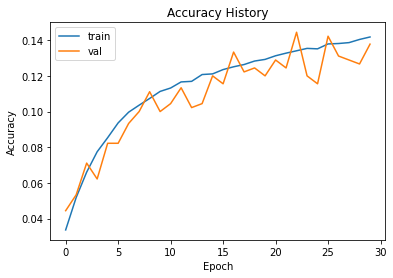

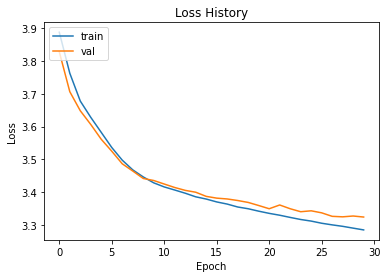

In [17]:
plot(train_history.history)

### Flops and Space Complexity
- https://pypi.org/project/model-profiler/
- https://pypi.org/project/keras-flops/

In [31]:
profile = model_profiler(model, 64, use_units = ['GPU IDs', 'MFLOPs', 'MB', 'Million', 'MB'])
print(profile)

| Model Profile                    | Value         | Unit    |
|----------------------------------|---------------|---------|
| Selected GPUs                    | None Detected | GPU IDs |
| No. of FLOPs                     | 0.0084        | MFLOPs  |
| GPU Memory Requirement           | 2.1456        | MB      |
| Model Parameters                 | 0.0651        | Million |
| Memory Required by Model Weights | 0.2484        | MB      |


In [25]:
def get_flops(model_h5_path):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()


    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(model_h5_path)

            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)

            return flops.total_float_ops

In [26]:
get_flops('/git/Yutai/DL_HW3')

194511